In [1]:

RANDOM_SEED = 1

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import f1_score


In [2]:
# initial work with the smaller data set
bank = pd.read_csv('bank.csv', sep = ';')  # start with smaller data set
# examine the shape of original input data
print(bank.shape)

(4521, 17)


In [3]:
# drop observations with missing data, if any
bank.dropna()
# examine the shape of input data after dropping missing data
print(bank.shape)

(4521, 17)


In [4]:
# look at the list of column names, note that y is the response
list(bank.columns.values)


['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'response']

In [5]:
# look at the beginning of the DataFrame
bank.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [6]:
# mapping function to convert text no/yes to integer 0/1
convert_to_binary = {'no' : 0, 'yes' : 1}

In [7]:
# define binary variable for having credit in default
default = bank['default'].map(convert_to_binary)


In [8]:
# define binary variable for having a mortgage or housing loan
housing = bank['housing'].map(convert_to_binary)

In [9]:
# define binary variable for having a personal loan
loan = bank['loan'].map(convert_to_binary)

In [10]:
# define response variable to use in the model
response = bank['response'].map(convert_to_binary)

In [11]:
# Combine into model data frame
model_df = pd.DataFrame({
    'default': default,
    'housing': housing,
    'loan': loan,
    'response': response
})

model_df.head()

,default,housing,loan,response
0,0,0,0,0
1,0,1,1,0
2,0,1,0,0
3,0,1,1,0
4,0,1,0,0


### Train - Test Split

In [12]:
# Import sklearn train test split
from sklearn.model_selection import train_test_split

In [13]:
# Split into train and test sets
train_set, test_set = train_test_split(model_df, test_size=0.2)

In [14]:
# Verify that the split occurred
train_shape = train_set.shape
test_shape = test_set.shape

print('Train set shape = {0}'.format(train_shape))
print('Test set shape = {0}'.format(test_shape))

Train set shape = (3616, 4)
Test set shape = (905, 4)


In [15]:

train_set.head()

,default,housing,loan,response
4340,0,1,0,0
2275,0,1,0,0
2900,0,0,0,0
2562,0,0,0,0
3981,0,0,0,0


In [16]:
# Create copy as to not modify train set during exploration
corr_df = train_set.copy()

### Correlation Matrix

In [17]:
# Correlation Matrix
corr_df.corr()

,default,housing,loan,response
default,1.000000,0.002959,0.075093,-0.009596
housing,0.002959,1.000000,0.013115,-0.104932
loan,0.075093,0.013115,1.000000,-0.078136
response,-0.009596,-0.104932,-0.078136,1.000000


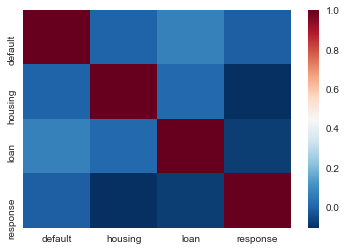

In [18]:
# Creat heatmap correlation matrix
sns.heatmap(corr_df.corr(), cmap="RdBu_r")

In [19]:
# Define function to calculate response ratio
def response_ratio(x):
  
  return np.sum(x) / np.size(x)

In [20]:

# Overall response ratio in our training data
resp_ratio = response_ratio(corr_df.response)
print('{0}% of respondents subscribed to long-term deposit.'.format(
    round(resp_ratio * 100, 2)))

11.67% of respondents subscribed to long-term deposit.


In [21]:
# Distributions
for i in corr_df.columns:
  ratio = response_ratio(corr_df[i])
  print('{0}% of respondents had a {1}'.format(round(ratio * 100, 1), i))

1.8% of respondents had a default
56.7% of respondents had a housing
15.6% of respondents had a loan
11.7% of respondents had a response


## Model 1: Logistic Regression
#### Create Model Object and Fit to Data

In [22]:

# Create model object
log_reg = LogisticRegression(C=10000)


In [23]:

# Split the train df into x & y
x_train_lr = train_set[['default','housing', 'loan']]
y_train_lr = train_set['response']

# Fit the model
log_reg.fit(x_train_lr, y_train_lr.ravel())

C:\Users\isabe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
print('x training dataset shape: ',x_train_lr.shape)
print('y training dataset shape: ',y_train_lr.shape)


x training dataset shape:  (3616, 3)
y training dataset shape:  (3616,)


In [25]:
# Review the coefficients
log_reg.coef_

array([[-0.07641091, -0.65089889, -0.85006038]])

In [26]:

# Predict y on the train set
y_pred_train_lr = log_reg.predict(x_train_lr)


#### Confusion Matrix

C:\Users\isabe\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


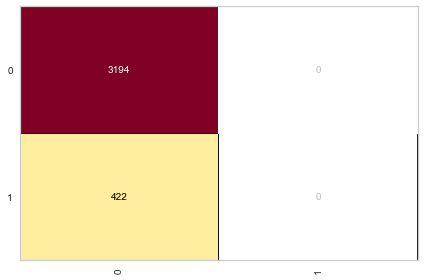

In [27]:
# Create confusion matrix
cm = ConfusionMatrix(log_reg, classes=[0,1])
cm.score(x_train_lr, y_train_lr)
plt.tight_layout()


### ROC Curve and AUC - Run Model Against Train Data

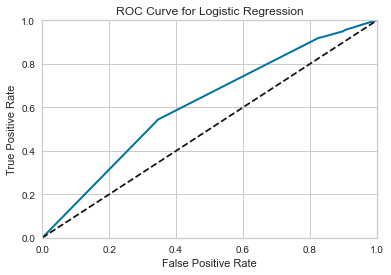

In [28]:
# Calculate Scores
y_scores_train_lr = log_reg.decision_function(x_train_lr)

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_train_lr, y_scores_train_lr)

# Create roc curve plotting function
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

# Plot the ROC Curve
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for Logistic Regression')
plt.show()

In [29]:
# Calculate the AUC
roc_auc_train_lr = roc_auc_score(y_train_lr,  y_scores_train_lr)
# Calculate the accuracy on the train set
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(log_reg.score(x_train_lr, y_train_lr)))
print('The area under the curve = {:.4f}'.format(roc_auc_train_lr))

Accuracy of logistic regression classifier on train set: 0.8833
The area under the curve = 0.6123


#### Cross Validation

In [30]:
# Create Cross Validation List to try different values
cv_list = [3,5,10]

# Define function that will return mean accuracy for different CV values
def cross_val_multiple(model, x_train_lr=x_train_lr, y_train_lr=y_train_lr, cv_list=cv_list):
  
  
#accuracy of k fold  
  for i in cv_list:
    cv_accuracy = cross_val_score(model, x_train_lr, y_train_lr, cv=i)
    print('The mean accuracy for {} cross fold validation = {:.6f}'.format(
        i,np.mean(cv_accuracy)))

In [31]:
# Run the cross validation
cross_val_multiple(log_reg)

The mean accuracy for 3 cross fold validation = 0.883297
The mean accuracy for 5 cross fold validation = 0.883297
The mean accuracy for 10 cross fold validation = 0.883298


C:\Users\isabe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\isabe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\isabe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\isabe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\isabe\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

#### Run Model Against Test Data

In [32]:
# Split the test df into x & y
x_test_lr = test_set[['housing', 'loan', 'default']]
y_test_lr = test_set['response']

In [33]:
# Make Predictions on test data
y_test_pred_lr = log_reg.predict(x_test_lr)



In [34]:
# View probabilities
log_reg.predict_proba(x_test_lr)

array([[0.84162871, 0.15837129],
       [0.84162871, 0.15837129],
       [0.84162871, 0.15837129],
       ...,
       [0.84162871, 0.15837129],
       [0.84162871, 0.15837129],
       [0.84162871, 0.15837129]])

### Precision and Recall

In [35]:
# Check precision and recall of model:
from sklearn.metrics import confusion_matrix, classification_report

# Predict test response:
y_pred_train_lr = log_reg.predict(x_train_lr)
y_pred_test_lr = log_reg.predict(x_test_lr)

print(classification_report(y_test_lr,y_pred_test_lr))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       806
           1       0.00      0.00      0.00        99

    accuracy                           0.89       905
   macro avg       0.45      0.50      0.47       905
weighted avg       0.79      0.89      0.84       905



C:\Users\isabe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### ROC Curve and AUC - Run Model Against Test Data

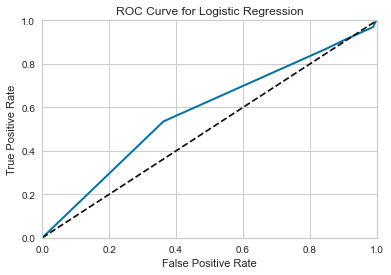

In [36]:
# Calculate Scores
y_scores_test_lr = log_reg.decision_function(x_test_lr)

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_lr, y_scores_test_lr)

# Create roc curve plotting function
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

# Plot the ROC Curve
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for Logistic Regression')
plt.show()

In [37]:

# Calculate Scores
y_scores_test_lr = log_reg.decision_function(x_test_lr)

# Calculate the AUC
roc_auc_test_lr = roc_auc_score(y_test_lr, y_scores_test_lr)


In [38]:
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(log_reg.score(x_train_lr, y_train_lr)))
print('The area under the curve = {:.4f}'.format(roc_auc_train_lr))
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(log_reg.score(x_test_lr, y_test_lr)))
print('The area under the curve = {:3f}'.format(roc_auc_test_lr))

Accuracy of logistic regression classifier on train set: 0.8833
The area under the curve = 0.6123
Accuracy of logistic regression classifier on test set: 0.8906
The area under the curve = 0.578684


#### Conclusion: Poor fit
##### I did not use the cross validation model on the test set due to no increase in accuracy.
##### Overall, the model performed as expected on the test data, but is still a poor predictor. 

In [39]:
# BernoulliNB is designed for binary/boolean features
from sklearn.naive_bayes import BernoulliNB

## Model 2: Naive Bayes
#### Create Model Object and Fit to Data

In [40]:
# Create model object
nb = BernoulliNB()

In [41]:
# Split the train df into x & y
x_train_nb = train_set[['default','housing', 'loan']]
y_train_nb = train_set['response']

# Fit the model
nb.fit(x_train_nb, y_train_nb)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [42]:
print('x training dataset shape: ',x_train_nb.shape)
print('y training dataset shape: ',y_train_nb.shape)

x training dataset shape:  (3616, 3)
y training dataset shape:  (3616,)


In [43]:
# Predict y on the train set
y_pred_train_nb = nb.predict(x_train_nb)



In [44]:
# View probabilities
nb.predict_proba(x_train_nb)

array([[0.90426999, 0.09573001],
       [0.90426999, 0.09573001],
       [0.83114238, 0.16885762],
       ...,
       [0.90426999, 0.09573001],
       [0.83114238, 0.16885762],
       [0.90426999, 0.09573001]])

#### Confusion Matrix

C:\Users\isabe\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


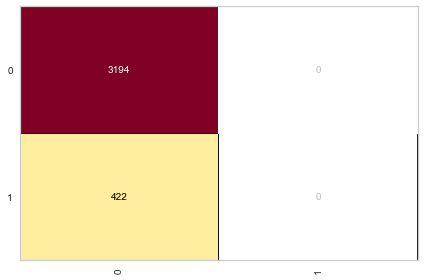

In [45]:
# Create confusion matrix
cm = ConfusionMatrix(nb, classes=[0,1])
cm.score(x_train_nb, y_train_nb)
plt.tight_layout()

### ROC Curve and AUC - Run Model Against Train Data

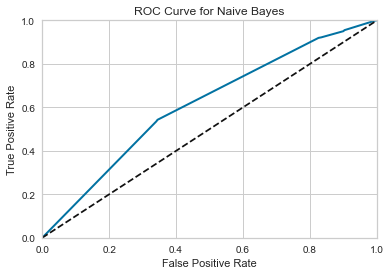

In [46]:
# Calculate Scores
y_scores_train_nb = nb.predict_proba(x_train_nb)

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_train_nb, y_scores_train_nb[:,1])

# Plot the ROC Curve
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for Naive Bayes')
plt.show()

In [47]:
# Calculate the AUC
roc_auc_train_nb = roc_auc_score(y_train_nb, y_scores_train_nb[:,1])

In [48]:
print('Accuracy of Naive Bayes classifier on train set: {:.4f}'.format(
    nb.score(x_train_nb, y_train_nb)))
print('The area under the curve = {:.4f}'.format(roc_auc_train_nb))

Accuracy of Naive Bayes classifier on train set: 0.8833
The area under the curve = 0.6123


#### Cross Validation

In [49]:
# Run the cross validation
cross_val_multiple(nb)

The mean accuracy for 3 cross fold validation = 0.883297
The mean accuracy for 5 cross fold validation = 0.883297
The mean accuracy for 10 cross fold validation = 0.883298


#### Run Model Against Test Data

In [50]:
# Split the test df into x & y
x_test_nb = test_set[['housing', 'loan', 'default']]
y_test_nb = test_set['response']

# Fit the model
nb.fit(x_test_nb, y_test_nb)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [51]:
# Predict y on the train set
y_pred_test_nb = nb.predict(x_test_nb)


In [52]:
# View probabilities
nb.predict_proba(x_test_nb)

array([[0.91797648, 0.08202352],
       [0.91797648, 0.08202352],
       [0.91797648, 0.08202352],
       ...,
       [0.91797648, 0.08202352],
       [0.91797648, 0.08202352],
       [0.91797648, 0.08202352]])

In [53]:
# Check precision and recall of model:
from sklearn.metrics import confusion_matrix, classification_report

# Predict test response:
y_pred_train_nb = nb.predict(x_train_nb)
y_pred_test_nb = nb.predict(x_test_nb)

print(classification_report(y_test_nb,y_pred_test_nb))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       806
           1       0.00      0.00      0.00        99

    accuracy                           0.89       905
   macro avg       0.45      0.50      0.47       905
weighted avg       0.79      0.89      0.84       905



C:\Users\isabe\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### ROC Curve and AUC - Run Model Against Test Data

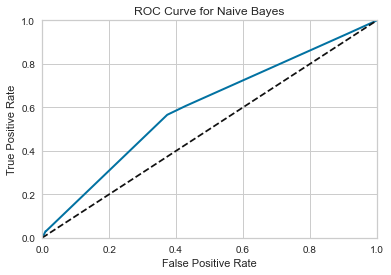

In [54]:
# Calculate Scores
y_scores_test_nb = nb.predict_proba(x_test_nb)

# Calculate fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_nb, y_scores_test_nb[:,1])

# Plot the ROC Curve
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for Naive Bayes')
plt.show()

In [55]:
# Calculate the AUC
roc_auc_test_nb = roc_auc_score(y_test_nb, y_scores_test_nb[:,1])

In [56]:
print('Accuracy of Naive Bayes classifier on train set: {:.4f}'.format(
    nb.score(x_train_nb, y_train_nb)))
print('The area under the curve = {:.4f}'.format(roc_auc_train_nb))

print('Accuracy of naive bayes classifier on test set: {:.4f}'.format(nb.score(x_test_nb, y_test_nb)))
print('The area under the curve = {:.4f}'.format(roc_auc_test_nb))

Accuracy of Naive Bayes classifier on train set: 0.8833
The area under the curve = 0.6123
Accuracy of naive bayes classifier on test set: 0.8906
The area under the curve = 0.5992


#### Conculsion: Not a great fit, but better than Logistic Regression Model
##### Accuracy was similar for both models (.88), but NB had a higher AUC than Logistic Regression